# ImageSegmentationDataset Class Usage

This notebook contains examples for how the [ImageSegmentationDataset](https://github.com/MIT-AI-Accelerator/multiearth-challenge/blob/c2318665ab94451eea4bd1b9e31a71655c6be001/src/multiearth_challenge/datasets/segmentation_dataset.py#L9) class can be used to sample data from the NetCDF files provided as part of the MultiEarth challenge.

In [45]:
import pkg_resources

from matplotlib import pyplot as plt
import numpy as np

from multiearth_challenge.datasets import segmentation_dataset as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Specifying Dataset Data
In this example, Sentinel-2 visible imagery will serve as the source imagery and deforestation segmentation masks will serve as the target imagery.

In [46]:
# Set data paths to sample data included as part of the MultiEarth repository
source_files = [pkg_resources.resource_filename("multiearth_challenge", "data/sample_dataset/sent2_sample.nc"),]
segmentation_files = [pkg_resources.resource_filename("multiearth_challenge", "data/sample_dataset/deforestation_sample.nc")]

Specify the bands to include for the source data. This is set with a dictionary whose keys are the sensor and the values are a list of bands.</br>
Acceptable sensor and band values are:</br>
"Landsat-5": ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'ST_B6', 'SR_B7', 'QA_PIXEL']</br>
"Landsat-8": ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL']</br>
"Sentinel-1": ['VV', 'VH']</br>
"Sentinel-2": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'QA60']</br>
"Fire": ['BurnDate', 'ConfidenceLevel', 'LandCover', 'ObservedFlag']</br>
"Deforestation": None, There is only a single unnamed band associated with the deforestation data so there are no bands to select</br>

The bands for the segmentation data are automatically selected for the two provided datasets. For deforestation data the one segmentation mask is selected. For fire data the "ConfidenceLevel" band is selected.

In [47]:
source_bands = {"Sentinel-2": ["B4", "B3", "B2"]} # RGB visible bands

### Creating the Dataset
Set additional parameters used by the ImageSegmentationDataset

In [48]:
# If True, returned source images will have multiple channels in increasing order of frequency (e.g., red, green, blue for visible), co-pol before cross-pol, and with bands not originating from collected imagery coming last and in alphabetical order. 
# The metadata returned with the imagery will also specify the channel order. If False, each band is treated as a separate sample.
merge_source_bands = False # bool

# The minimum and maximum allowable cloud coverage allowed in visible and IR imagery as a fraction [0, 1]. 
# Setting the maximum above 0 may be useful when incorporating SAR imagery into a multimodal model where a large fraction of cloud coverage may be acceptable. 
# Similarly, evaluation in challenging cases with a minimum on the amount of cloud coverage may be desired.
# Note, there may be some innacuracies in the identified cloud coverage provided by the sensor's QA bands. This is especially true for Sentinel-2 data.
source_cloud_coverage = (0.0, 0.0) # Tuple[float, float]

# The minimum and maximum inclusive relative time window in days around the segmentation image from which source imagery is pulled. 
# If the minimum is None, there is no filter on the minimum relative date. Similarly, no maximum can be specified with a value of None.
# For example, with a value of (-7, 7) only source imagery within the interval of -7 days before and 7 days after a segmentation image date will be returned as source imagery. 
source_date_window = (-7, 7) # Tuple[Optional[float], Optional[float]]

# If True, for each target image only a single source image is returned in a unique pair. A single source image may be paired with multiple target images and vice-versa depending on data filters applied. 
# If False, each target image is returned with all source images at the same location that satisfy applied data filters. This may be useful if you want to include information from multiple images when making a single segmentation prediction.
single_source_image = True

# If True, if no source or target image remain after data filtering, raise a ValueError, otherwise this dataset will have length 0. 
error_on_empty = True # bool

Create the dataset. The sample data is small, but depending on the number of images contained in the NetCDF files, calculating the cloud coverage statistics may take several minutes.

In [49]:
dataset = sd.ImageSegmentationDataset(
    source_files,
    segmentation_files,
    source_bands,
    merge_source_bands,
    source_cloud_coverage,
    source_date_window,
    single_source_image,
    error_on_empty,
)   

RuntimeError: NetCDF: HDF error

### Data Returned by the Dataset
The dataset serves as a sequence of samples. Each call to \_\_getitem__ will return a two element tuple where the second element holds a dictionary with a single target image and associated metadata. The first element holds a list of dictionaries where each one holds a source image along with associated metadata at the same location that satisfies the source_date_window. If single_source_image is True, this will always be a one element list with the multiple possible pairings being returned as separate samples.

Note, for this example the returned source data is cloud free and within +- 10 days of the target deforestation segmentation image date. Cloud coverage is determined by information in the sensor's QA band, which may have inaccuracies.

In [ ]:
print(f"Number of dataset samples: {len(dataset)}")

# Get sample with index 0
source_data, target_data = dataset[0]

# The returned source_data is a list of all data related to a target image. 
# During initialization since single_source_image was set to True, this list will always have one element.
print(f"Source data key values returned: {source_data[0].keys()}")
print(f"Target data key values returned: {target_data.keys()}")

Number of dataset samples: 9
Source data key values returned: dict_keys(['image', 'data_source', 'bands', 'lat_lon', 'date'])
Target data key values returned: dict_keys(['image', 'data_source', 'bands', 'lat_lon', 'date'])


### Single channel vs. Multi-channel Imagery
The returned source images in the dataset above are single band and there are separate paired samples for each band. Below is an example where the bands have been merged into a 3-channel RGB image.

In [ ]:
# Make a second dataset with merged bands
merge_source_bands = True
dataset_merged_bands = sd.ImageSegmentationDataset(
    source_files,
    segmentation_files,
    source_bands,
    merge_source_bands,
    source_cloud_coverage,
    source_date_window,
    single_source_image,
    error_on_empty,
)
                  
# 1/3 target samples have been merged resulting in 1/3 of the number of samples compared to separate bands.
print(f"Number of merged band dataset samples: {len(dataset_merged_bands)}")
# Get sample with index 0
source_data_merged_bands, target_data_merged_bands = dataset_merged_bands[0]
print(f"Shape of the source image without merging bands: {source_data[0]['image'].shape}")
print(f"List of bands associated with the single band source image: {source_data[0]['bands']}")
print(f"Shape of the source image with merged bands: {source_data_merged_bands[0]['image'].shape}")
print(f"List of bands associated with the multi-band source image: {source_data_merged_bands[0]['bands']}") # This list corresponds to the channels in the image with the first band corresponding to channel index 0, the second channel index 1, etc.

Number of merged band dataset samples: 3
Shape of the source image without merging bands: (1, 256, 256)
List of bands associated with the single band source image: ['B4']
Shape of the source image with merged bands: (3, 256, 256)
List of bands associated with the multi-band source image: ['B4', 'B3', 'B2']


### Image Characteristics
The collected images may require normalization for visualization. Here we perform a simple normalization without color balancing.</br>
Also, it should be noted that the filtering of cloudy images uses the Sentinel-2 QA band which may have inaccuracies resulting in some images with high pixel value cloud coverage obscuring land. Additional filtering or masking of cloud coverage can be applied if needed.

In [ ]:
def normalize(img):
    img = img.astype(np.float64)
    img -= np.min(img)
    img /= np.max(img)
    return img

1

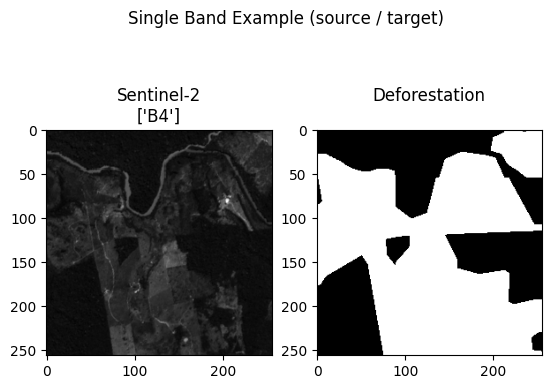

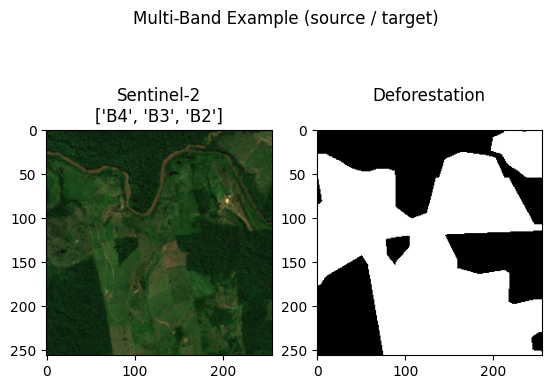

In [ ]:
fig1, axs1 = plt.subplots(1, 2)
fig1.suptitle("Single Band Example (source / target)")
axs1[0].set_title(f"{source_data[0]['data_source']}\n{source_data[0]['bands']}")
_ = axs1[0].imshow(normalize(source_data[0]["image"]).squeeze(), cmap="gray")
axs1[1].set_title(f"{target_data['data_source']}\n")
_ = axs1[1].imshow(target_data["image"].squeeze(), cmap="gray")

fig2, axs2 = plt.subplots(1, 2)
fig2.suptitle("Multi-Band Example (source / target)")
axs2[0].set_title(f"{source_data_merged_bands[0]['data_source']}\n{source_data_merged_bands[0]['bands']}")
_ = axs2[0].imshow(normalize(source_data_merged_bands[0]["image"]).transpose((1, 2, 0)))
axs2[1].set_title(f"{target_data_merged_bands['data_source']}\n")
_ = axs2[1].imshow(target_data_merged_bands["image"].squeeze(), cmap="gray")

In [ ]:
def comp_ref(vet_img,vet_mask):
    vetor_diff =[]

    for img, mask in zip(vet_img, vet_mask):
        rse = np.sqrt(np.mean(np.power(img.astype(np.int32) - mask.astype(np.int32), 2)))
        print("{:.4f}".format(rse))
        vetor_diff.append(rse)
    return vetor_diff


In [ ]:
diff_io_otsu = comp_ref(io_otsu0, vetor_mask)

### Closing the Datasets
The ImageSegmentationDataset class holds open file handles to NetCDF files which need to be manually closed.

In [ ]:
dataset.close()
dataset_merged_bands.close()

### Incorporation into Training and Evaluation
This dataset can be wrapped in a straightforward manner for use in a desired ML training / evaluation framework, allowing for selection of desired data from within the returned dictionary, applying data transforms such as image resizing, and converting to framework compatible types.